In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
from astropy.io import fits

In [29]:
def load_file(i:int) -> np.array:
    if (i > 5) or (i<0):
        i = 5
    hdul = fits.open(f'data/Image10466{i}.fits')
    return hdul[0].data[40:4124,5:2040]

def gen_binary(i:int = 0, limit:int = 4000) -> np.array:
    data = load_file(i)
    data[data < limit] = 0
    data[data >= limit] = 1
    return data

def check_nbors(i,j, queue):
    global w,h
    n_bors = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),         ( 0,1),
              ( 1,-1), ( 1,0), ( 1,1)]
    for n in n_bors:
        n_bor = (n[0]+i,n[1]+j)
        # Is n_bor on grid?
        if (n_bor[0]<0) or (n_bor[0]==h) or (n_bor[1]<0) or (n_bor[1]==w):
            continue
        if (data[n_bor]>0)&(clusters[n_bor]==-1):
            clusters[n_bor] = clusters[i,j]
            queue.put(n_bor)

In [30]:
data = gen_binary()

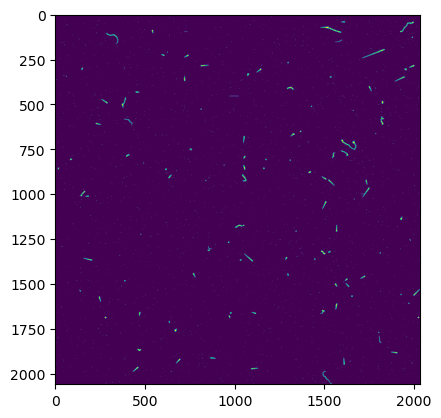

'maxc = np.max(clusters)+1\nvalues = np.zeros(maxc,dtype=float)\nfor c in range(maxc):\n    mask = clusters==c\n    values[c]+=(np.sum(data[mask]))\nvalues '

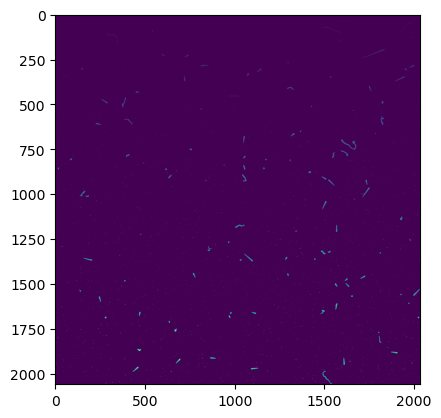

In [32]:
plt.imshow(data)

h,w = data.shape
plt.show()


clusters = -1* np.ones_like(data)
    
queue = Queue()
c = 0
for i in range(h):
    for j in range(w):
        if (clusters[i,j]==-1)&(data[i,j]>0):
            clusters[i,j] = c
            c+=1
            check_nbors(i,j,queue)
        while not queue.empty():
            check_nbors(*queue.get(),queue)
plt.imshow(clusters)

In [100]:
def calc_square(index:int,clusters:np.array):
    imax,jmax = clusters.shape
    active_inds = np.argwhere(clusters == index).T
    picture =  clusters[np.min(active_inds[0]):np.max(active_inds[0])+1,
                    np.min(active_inds[1]):np.max(active_inds[1])+1]
    return picture==index
def save_pic(pic:np.array,fname:str,size:int=None):
    np.savetxt("clusters/"+fname, np.pad(pic,1), delimiter=",",fmt="%i")

In [99]:
dimmax = 0
for c in range(clusters.max()+1):
    if np.sum(clusters == c)<2:
        continue
    pic = calc_square(c,clusters)
    dim = max(pic.shape)
    if dim > dimmax:
        dimmax = dim
print(dimmax)

126


In [ ]:
for c in range(clusters.max()+1):
    if np.sum(clusters == c)<2:
        continue
    pic = calc_square(c,clusters)
    save_pic(pic, f"00000{c}.csv"[-8:])